<a href="https://colab.research.google.com/github/q1mora/cnt-property-prediction-using-ml-architectures/blob/ml/chirality_kans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install pykan
from kan import KAN #importing KAN module
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time



In [15]:
# set manual seeds
seed = 43
torch.manual_seed(seed)
torch.manual_seed(seed)

num_epochs = 300
learning_rate = 0.0005
batch_size = 32

In [16]:
# load in dataset
data = pd.read_csv('/content/Chirality_Indices_Data_.csv')  # change filename

features = ['n', 'm', 'modulus']
target = 'metallicity'

x = data[features].values
y = data[target].values

In [17]:

# split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=seed, stratify=y
)

# scaling features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

class ChiralityDataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.tensor(x, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

train_dataset = ChiralityDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = ChiralityDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# these layers replace MLP layers (MLP(nn.Module))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using device: {device}')

kans_layers = [x_train_scaled.shape[1], 16, 8, 1] # layers
model = KAN(kans_layers).to(device)

print(model)

using device: cuda
checkpoint directory created: ./model
saving model version 0.0
MultKAN(
  (act_fun): ModuleList(
    (0-2): 3 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-2): 3 x Symbolic_KANLayer()
  )
)


In [19]:
# training and evaluation setup
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion.to(device)


print('start training')
start_time = time.time()

for epoch in range(num_epochs):
  model.train()
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels.float())
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if (epoch+1) % 10 == 0:
    print(f'epoch [{epoch+1}/{num_epochs}], loss: {loss.item(): .4f}')

end_time = time.time()
print('training finished')

total_training_time = end_time - start_time
print(f'total training time: {total_training_time: .2f} seconds')



start training
epoch [10/300], loss:  0.8504
epoch [20/300], loss:  0.6657
epoch [30/300], loss:  0.6132
epoch [40/300], loss:  0.5685
epoch [50/300], loss:  0.5149
epoch [60/300], loss:  0.5265
epoch [70/300], loss:  0.4468
epoch [80/300], loss:  0.5168
epoch [90/300], loss:  0.4364
epoch [100/300], loss:  0.3854
epoch [110/300], loss:  0.3797
epoch [120/300], loss:  0.3552
epoch [130/300], loss:  0.3204
epoch [140/300], loss:  0.2675
epoch [150/300], loss:  0.2697
epoch [160/300], loss:  0.2047
epoch [170/300], loss:  0.1551
epoch [180/300], loss:  0.1624
epoch [190/300], loss:  0.1348
epoch [200/300], loss:  0.0868
epoch [210/300], loss:  0.1065
epoch [220/300], loss:  0.0680
epoch [230/300], loss:  0.0581
epoch [240/300], loss:  0.0385
epoch [250/300], loss:  0.0368
epoch [260/300], loss:  0.0283
epoch [270/300], loss:  0.0373
epoch [280/300], loss:  0.0272
epoch [290/300], loss:  0.0274
epoch [300/300], loss:  0.0227
training finished
total training time:  537.32 seconds


In [20]:
# calculating accuracy
print('start testing\n')
model.eval()
correct = 0
total = 0

model.to(device)

print('start testing inference \n')
inference_start_time = time.time()

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(inputs)
    # applying sigmoid and round to get binary classifications
    predicted = torch.round(torch.sigmoid(outputs))

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

inference_end_time = time.time()
accuracy = 100 * correct / total
print(f'accuracy of the model on the {total} test samples: {accuracy: .2f} %\n')

# printing inference time resuts
total_inference_time = inference_end_time - inference_start_time
avg_inference_time_per_sample = (total_inference_time / total) * 1000 # in milliseconds

print(f'total inference time for {total} samples: {total_inference_time: .4f} seconds\n')
print(f'average inference time per sample: {avg_inference_time_per_sample: .4f} ms')

start testing

start testing inference 

accuracy of the model on the 72 test samples:  100.00 %

total inference time for 72 samples:  0.1896 seconds

average inference time per sample:  2.6327 ms


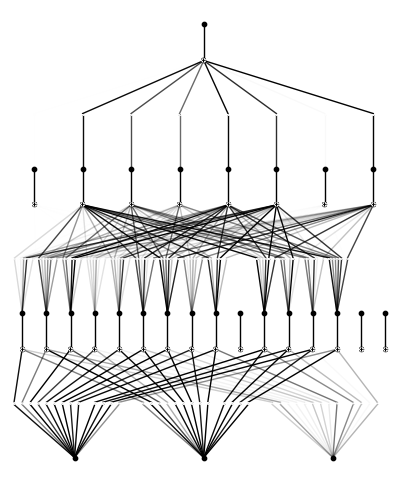

In [21]:
# plotting the model and saving the results in a folder
# this creates an html file in browser and notebook

model.plot(folder='kan_plot', scale=0.5)

In [22]:
pruned_model = model.prune()
print(f'model pruned successfully. {pruned_model}')

try:
  formula, _ = pruned_model.symbolic_formula()
  print('symbolic formula')
  print(formula)

except Exception as e:
  print(f'could not generate symbolic formula: {e}')
  print(f'this can happen if the model is still too complex')

saving model version 0.1
model pruned successfully. MultKAN(
  (act_fun): ModuleList(
    (0-2): 3 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-2): 3 x Symbolic_KANLayer()
  )
)
symbolic formula
[0]


/usr/local/lib/python3.12/dist-packages/sympy/core/sympify.py:449: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return sympify(float(a))
